In [1]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
# Load and preprocess the dataset
data_path = 'ckextended.csv' 
data = pd.read_csv(data_path)
X = []
y = []


In [3]:
for i, row in data.iterrows():
    pixel_data = row['pixels']
    if isinstance(pixel_data, str):  # Validate that pixel data is a string
        pixels = list(map(int, pixel_data.split(' ')))
        if len(pixels) == 48 * 48:  # Ensure the pixel data is of correct length
            image = np.array(pixels).reshape(48, 48).astype(np.uint8)
            if image is not None and image.size > 0:
                image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_CUBIC)
                X.append(image)
                y.append(row['emotion'])
            else:
                print(f"Skipping image {i}: Invalid image data")
        else:
            print(f"Skipping row {i}: Pixel data length is {len(pixels)} instead of 48x48.")
    else:
        print(f"Skipping row {i}: Pixel data is not valid.")


In [4]:
# Convert lists to NumPy arrays for model training
X = np.array(X)
y = np.array(y)

# Normalize and reshape for the model
X = np.expand_dims(X, axis=-1)
X = np.repeat(X, 3, axis=-1)  # Convert grayscale to RGB
X = X / 255.0  # Normalize the pixel values


In [5]:
# Define emotion dictionary
emotion_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
# Filter out any samples where the label is not in the range 0-6
valid_indices = [i for i, label in enumerate(y) if label in emotion_dict]
X = np.array([X[i] for i in valid_indices])
y = np.array([y[i] for i in valid_indices])

# Print shapes for debugging
print("Final X shape:", X.shape)
print("Final y shape:", y.shape)


Final X shape: (902, 224, 224, 3)
Final y shape: (902,)


In [6]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def preprocess_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

def create_dataset(images, labels, batch_size, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_training:
        dataset = dataset.shuffle(buffer_size=len(images))
        dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [7]:

# Create datasets
batch_size = 32
train_dataset = create_dataset(X_train, y_train, batch_size)
test_dataset = create_dataset(X_test, y_test, batch_size, is_training=False)


In [8]:
# Define the LeNet-5 model architecture
def create_lenet5(input_shape):
    model = Sequential()
    model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=input_shape, padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', padding='valid'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(120, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dropout(0.5))  # Dropout layer
    model.add(Dense(84, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dropout(0.5))  # Dropout layer
    model.add(Dense(7, activation='softmax'))
    
    return model
# Input shape for the LeNet model: 224x224 images with 3 channels (RGB)
input_shape = (224, 224, 3)

# Create the LeNet-5 model
lenet5_model = create_lenet5(input_shape)

# Compile the model
lenet5_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
lenet5_model.summary()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 108, 108, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │     5,598,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           595 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,612,471 (21.41 MB)

 Trainable params: 5,612,471 (21.41 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Train the model
history = lenet5_model.fit(train_dataset, 
                           epochs=50, 
                           validation_data=test_dataset,
                           callbacks=[early_stopping, lr_reduction])


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 287ms/step - accuracy: 0.4192 - loss: 3.2311 - val_accuracy: 0.6740 - val_loss: 1.5213 - learning_rate: 0.0010
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 301ms/step - accuracy: 0.6542 - loss: 1.6206 - val_accuracy: 0.6740 - val_loss: 1.5595 - learning_rate: 0.0010
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 313ms/step - accuracy: 0.6728 - loss: 1.4927 - val_accuracy: 0.6740 - val_loss: 1.2817 - learning_rate: 0.0010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 275ms/step - accuracy: 0.6505 - loss: 1.3885 - val_accuracy: 0.6740 - val_loss: 1.1842 - learning_rate: 0.0010
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 270ms/step - accuracy: 0.6460 - loss: 1.3106 - val_accuracy: 0.6740 - val_loss: 1.1822 - learning_rate: 0.0010
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 259ms/step - accuracy: 0.6424 - loss: 1.2116 - val_accuracy: 0.7017 - val_loss: 1.0113 - learning_rate: 0.0010
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 268ms/step - accuracy: 0.7125 - loss: 1.0846 - 

In [10]:
# Evaluate the model on test data
test_loss, test_acc = lenet5_model.evaluate(test_dataset)
print(f'Test Accuracy: {test_acc:.4f}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8328 - loss: 0.6431
Test Accuracy: 0.8564


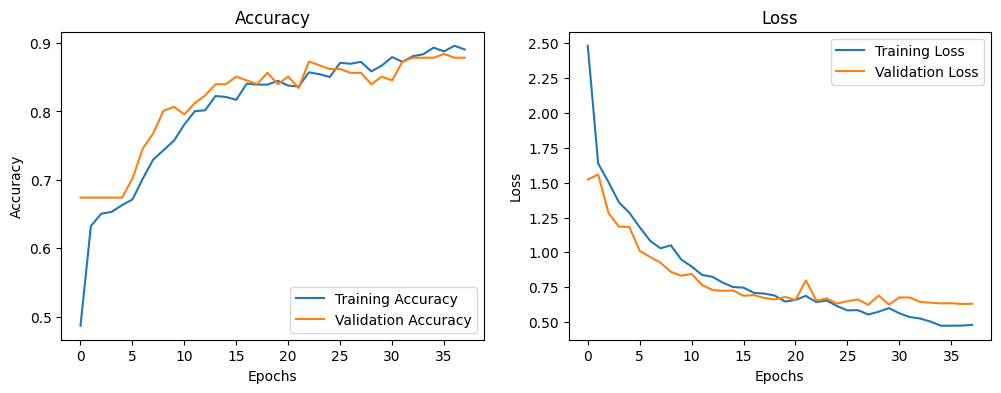

In [11]:
# Plot the training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot training history
plot_training_history(history)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


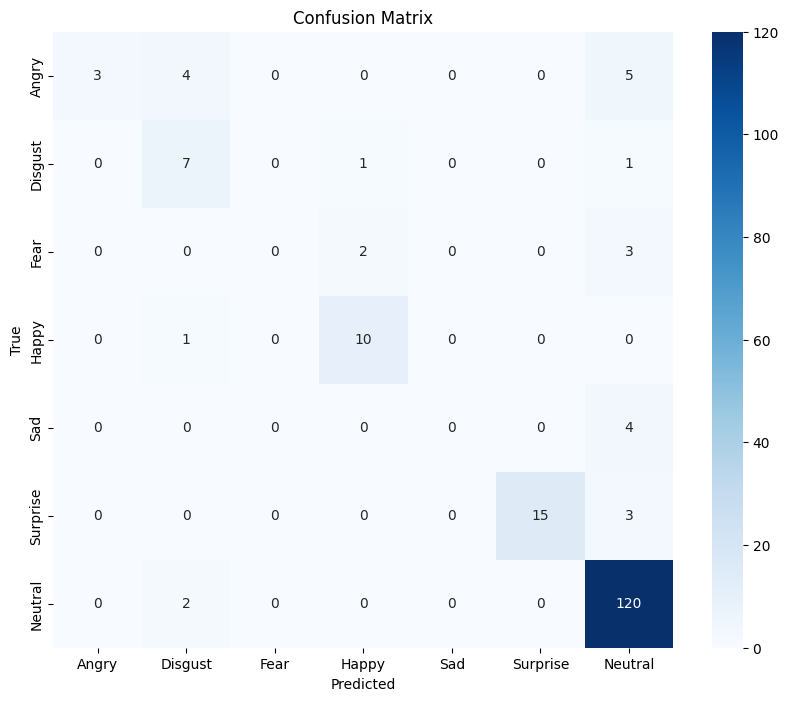

Classification Report:
               precision    recall  f1-score   support

       Angry       1.00      0.25      0.40        12
     Disgust       0.50      0.78      0.61         9
        Fear       0.00      0.00      0.00         5
       Happy       0.77      0.91      0.83        11
         Sad       0.00      0.00      0.00         4
    Surprise       1.00      0.83      0.91        18
     Neutral       0.88      0.98      0.93       122

    accuracy                           0.86       181
   macro avg       0.59      0.54      0.53       181
weighted avg       0.83      0.86      0.82       181



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [12]:
# Predict the labels for the test dataset
y_pred_probs = lenet5_model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)  # Get the predicted class labels

# Get the true labels from the test dataset
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_dict.values(), yticklabels=emotion_dict.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report for detailed metrics
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=emotion_dict.values()))

In [13]:
lenet5_model.save("letnet5model345.h5")

In [14]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [15]:
# Load and preprocess the dataset
data_path = 'ckextended.csv' 
data = pd.read_csv(data_path)
X = []
y = []
for i, row in data.iterrows():
    pixel_data = row['pixels']
    if isinstance(pixel_data, str):  # Validate that pixel data is a string
        pixels = list(map(int, pixel_data.split(' ')))
        if len(pixels) == 48 * 48:  # Ensure the pixel data is of correct length
            image = np.array(pixels).reshape(48, 48).astype(np.uint8)
            
            if image is not None and image.size > 0:
                # Apply preprocessing steps
                image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_CUBIC)

                # Apply histogram equalization
                image = cv2.equalizeHist(image)
                
                # Apply Gaussian blur
                image = cv2.GaussianBlur(image, (5, 5), 0)
                
                # Apply Canny edge detection
                image = cv2.Canny(image, 100, 200)
                
                X.append(image)
                y.append(row['emotion'])
            else:
                print(f"Skipping image {i}: Invalid image data")
        else:
            print(f"Skipping row {i}: Pixel data length is {len(pixels)} instead of 48x48.")
    else:
        print(f"Skipping row {i}: Pixel data is not valid.")

In [16]:
# Convert lists to NumPy arrays for model training
X = np.array(X)
y = np.array(y)

# Normalize and reshape for the model
X = np.expand_dims(X, axis=-1)
X = np.repeat(X, 3, axis=-1)  # Convert grayscale to RGB (3 channels)
X = X / 255.0  # Normalize pixel values

# Define emotion dictionary
emotion_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Filter out any samples where the label is not in the range 0-6
valid_indices = [i for i, label in enumerate(y) if label in emotion_dict]
X = np.array([X[i] for i in valid_indices])
y = np.array([y[i] for i in valid_indices])

# Print shapes for debugging
print("Final X shape:", X.shape)
print("Final y shape:", y.shape)

Final X shape: (902, 224, 224, 3)
Final y shape: (902,)


In [17]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def preprocess_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

def create_dataset(images, labels, batch_size, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_training:
        dataset = dataset.shuffle(buffer_size=len(images))
        dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [18]:
# Create datasets
batch_size = 32
train_dataset = create_dataset(X_train, y_train, batch_size)
test_dataset = create_dataset(X_test, y_test, batch_size, is_training=False)

# Define the LeNet-5 model architecture
def create_lenet5(input_shape):
    model = Sequential()
    model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=input_shape, padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', padding='valid'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(120, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dropout(0.5))  # Dropout layer
    model.add(Dense(84, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dropout(0.5))  # Dropout layer
    model.add(Dense(7, activation='softmax'))
    
    return model

# Input shape for the LeNet model: 224x224 images with 3 channels (RGB)
input_shape = (224, 224, 3)

# Create the LeNet-5 model
lenet5_model = create_lenet5(input_shape)

# Compile the model
lenet5_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
lenet5_model.summary()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 112, 112, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 108, 108, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 120)            │     5,598,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           595 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,612,471 (21.41 MB)

 Trainable params: 5,612,471 (21.41 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Train the model
history = lenet5_model.fit(train_dataset, 
                           epochs=50, 
                           validation_data=test_dataset,
                           callbacks=[early_stopping, lr_reduction])
# Evaluate the model on test data
test_loss, test_acc = lenet5_model.evaluate(test_dataset)
print(f'Test Accuracy: {test_acc:.4f}')


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 266ms/step - accuracy: 0.4659 - loss: 2.1510 - val_accuracy: 0.6740 - val_loss: 1.5077 - learning_rate: 0.0010
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 263ms/step - accuracy: 0.6213 - loss: 1.6872 - val_accuracy: 0.6740 - val_loss: 1.3579 - learning_rate: 0.0010
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 261ms/step - accuracy: 0.6277 - loss: 1.5398 - val_accuracy: 0.6961 - val_loss: 1.2006 - learning_rate: 0.0010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - accuracy: 0.7147 - loss: 1.2005 - val_accuracy: 0.7127 - val_loss: 1.0764 - learning_rate: 0.0010
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 262ms/step - accuracy: 0.7147 - loss: 1.1009 - val_accuracy: 0.7569 - val_loss: 1.0457 - learning_rate: 0.0010
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 271ms/step - accuracy: 0.7603 - loss: 1.0140 - val_accuracy: 0.7790 - val_loss: 0.9432 - learning_rate: 0.0010
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 262ms/step - accuracy: 0.7923 - loss: 0.9203 - 

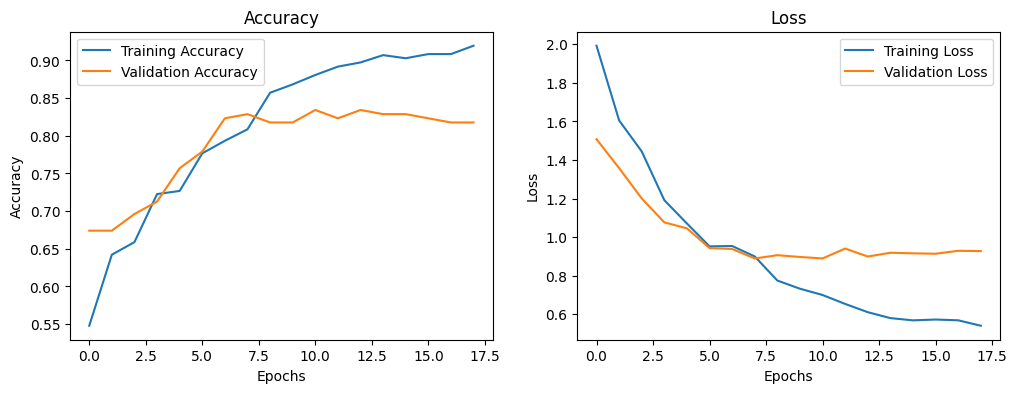

In [20]:
# Plot the training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot training history
plot_training_history(history)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


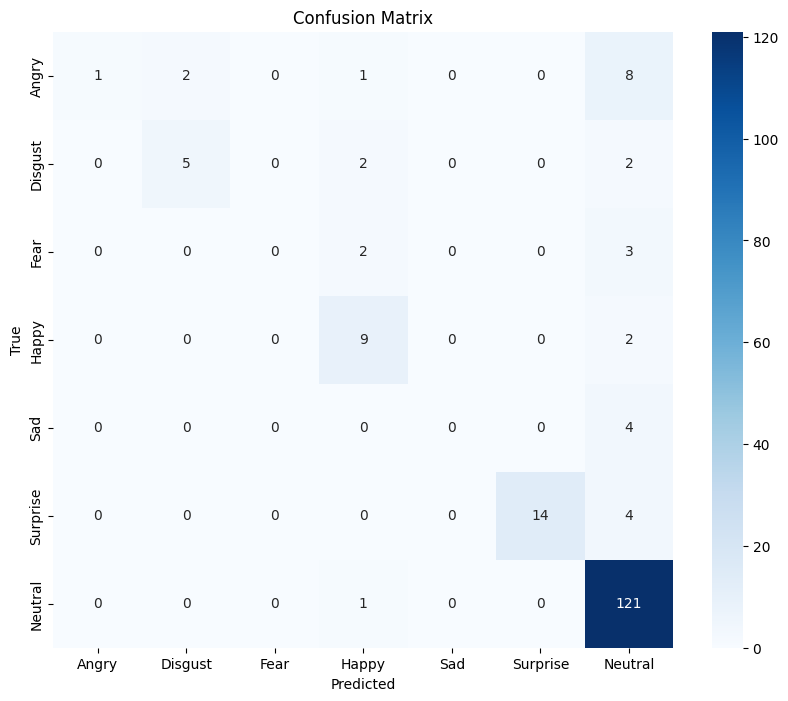

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Classification Report:
               precision    recall  f1-score   support

       Angry       1.00      0.08      0.15        12
     Disgust       0.71      0.56      0.63         9
        Fear       0.00      0.00      0.00         5
       Happy       0.60      0.82      0.69        11
         Sad       0.00      0.00      0.00         4
    Surprise       1.00      0.78      0.88        18
     Neutral       0.84      0.99      0.91       122

    accuracy                           0.83       181
   macro avg       0.59      0.46      0.47       181
weighted avg       0.80      0.83      0.78       181



In [21]:
# Predict the labels for the test dataset
y_pred_probs = lenet5_model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)  # Get the predicted class labels

# Get the true labels from the test dataset
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_dict.values(), yticklabels=emotion_dict.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report for detailed metrics
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=emotion_dict.values()))

# Save the model
lenet5_model.save("letnet5model_with_preprocessing.h5")